Copyright (c) 2015, 2016 [Sebastian Raschka](sebastianraschka.com)
<br>
[Li-Yi Wei](http://liyiwei.org/)

https://github.com/1iyiwei/pyml

[MIT License](https://github.com/1iyiwei/pyml/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 10 - Predicting Continuous Target Variables with Regression Analysis

We talk only about classification so far

Regression is also important

## Classification versus regression

Classification: discrete output
<img src='./images/01_03.png'>

Regression: continuous output
<img src='./images/01_04.png' width=50%>

Both are supervised learning
* require target variables

More similar than they appear
* similar principles, e.g. optimization
* similar goals, e.g. linear decision boundary for classification versus line fitting for regression


Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,pandas,matplotlib,sklearn,seaborn

last updated: 2016-10-01 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
sklearn 0.17.1
seaborn 0.7.1


*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

### Overview

- [Introducing a simple linear regression model](#Introducing-a-simple-linear-regression-model)
- [Exploring the Housing Dataset](#Exploring-the-Housing-Dataset)
  - [Visualizing the important characteristics of a dataset](#Visualizing-the-important-characteristics-of-a-dataset)
- [Implementing an ordinary least squares linear regression model](#Implementing-an-ordinary-least-squares-linear-regression-model)
  - [Solving regression for regression parameters with gradient descent](#Solving-regression-for-regression-parameters-with-gradient-descent)
  - [Estimating the coefficient of a regression model via scikit-learn](#Estimating-the-coefficient-of-a-regression-model-via-scikit-learn)
- [Fitting a robust regression model using RANSAC](#Fitting-a-robust-regression-model-using-RANSAC)
- [Evaluating the performance of linear regression models](#Evaluating-the-performance-of-linear-regression-models)
- [Using regularized methods for regression](#Using-regularized-methods-for-regression)
- [Turning a linear regression model into a curve - polynomial regression](#Turning-a-linear-regression-model-into-a-curve---polynomial-regression)
  - [Modeling nonlinear relationships in the Housing Dataset](#Modeling-nonlinear-relationships-in-the-Housing-Dataset)
  - [Dealing with nonlinear relationships using random forests](#Dealing-with-nonlinear-relationships-using-random-forests)
    - [Decision tree regression](#Decision-tree-regression)
    - [Random forest regression](#Random-forest-regression)
- [Summary](#Summary)

In [2]:
from IPython.display import Image

%matplotlib inline

# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

# Introducing a simple linear regression model

Model:
$
y = \sum_{i=0}^n w_i x_i = \mathbf{w}^T \mathbf{x}
$
with $x_0 = 1$.

Given a collection of sample data $\{\mathbf{x^{(i)}}, y^{(i)} \}$, find the line $\mathbf{w}$ that minimizes the regression error:
$$
\begin{align}
L(X, Y, \mathbf{w}) 
= \sum_i \left( y^{(i)} - \hat{y}^{(i)} \right)^2 
= \sum_i \left( y^{(i)} - \mathbf{w}^T \mathbf{x}^{(i)} \right)^2
\end{align}
$$

## 2D case

$
y = w_0 + w_1 x
$

<img src='./images/10_01.png' width=90%> 

# General regression models

We can fit different analytic models/functions (not just linear ones) to a given dataset.

Start a linear one with a real-data set first
* easier to understand and interpret (e.g. positive/negative correlation) 
* less prone for over-fitting 

Followed by non-linear models

# Exploring the Housing dataset

Let's explore a realistic problem: predicting house prices based on their features.

This is a regression problem
* house prices are continuous variables not discrete categories

Source: [https://archive.ics.uci.edu/ml/datasets/Housing](https://archive.ics.uci.edu/ml/datasets/Housing)

Boston suburbs

Attributes (1-13) and target (14):
    
<pre>
1. CRIM      per capita crime rate by town
2. ZN        proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS     proportion of non-retail business acres per town
4. CHAS      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX       nitric oxides concentration (parts per 10 million)
6. RM        average number of rooms per dwelling
7. AGE       proportion of owner-occupied units built prior to 1940
8. DIS       weighted distances to five Boston employment centres
9. RAD       index of accessibility to radial highways
10. TAX      full-value property-tax rate per $10,000
11. PTRATIO  pupil-teacher ratio by town
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT    % lower status of the population
14. MEDV     Median value of owner-occupied homes in $1000's
</pre>

## Read the dataset

In [3]:
import pandas as pd

# online dataset
data_src = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
# local dataset
data_src = '../datasets/housing/housing.data'

df = pd.read_csv(data_src,
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

<hr>

### Note:


If the link to the Housing dataset provided above does not work for you, you can find a local copy in this repository at [./../datasets/housing/housing.data](./../datasets/housing/housing.data).

Or you could fetch it via

In [4]:
if False:
    df = pd.read_csv('https://raw.githubusercontent.com/1iyiwei/pyml/master/code/datasets/housing/housing.data',
                      header=None, sep='\s+')

    df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
                  'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
                  'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
    df.head()

## Visualizing the important characteristics of a dataset

Before applying analysis and machine learning, it can be good to observate the dataset
* interesting trends that can lead to questions for analysis/ML
* issues in the datasets, such as missing entries, outliers, noises, etc.

[Exploratory data analysis (EDA)](https://en.wikipedia.org/wiki/Exploratory_data_analysis)

Use scatter plots to visualize the correlations between pairs of features.

In the seaborn library below, the diagonal lines are histograms for single features.

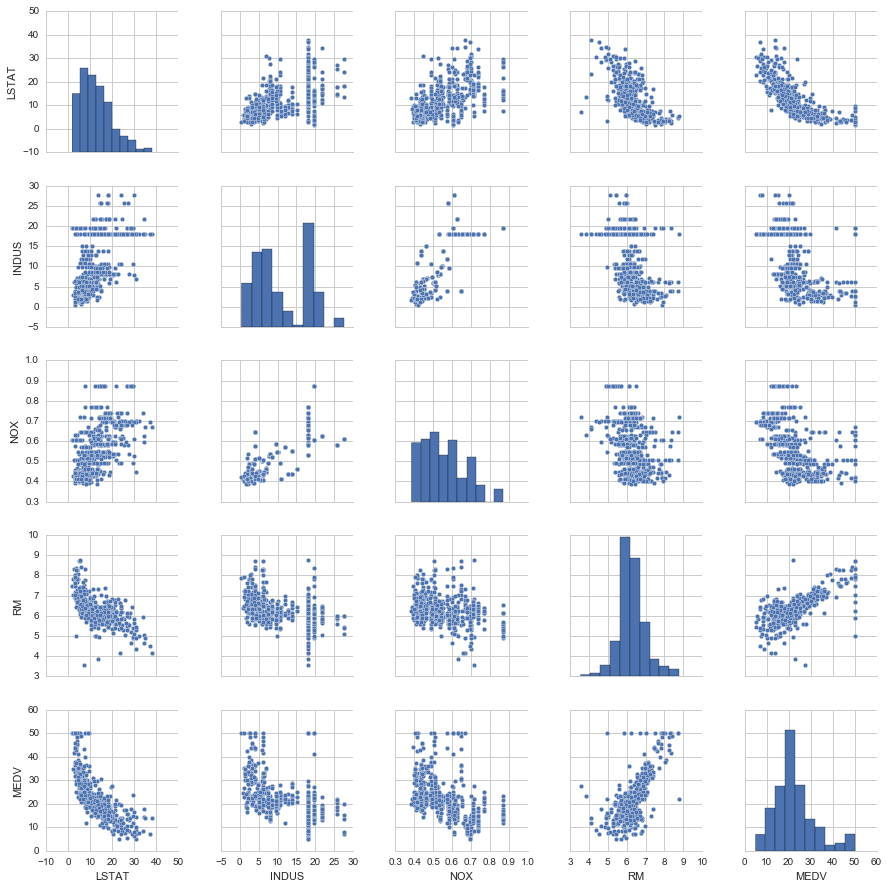

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

sns.pairplot(df[cols], size=2.5)
plt.tight_layout()
# plt.savefig('./figures/scatter.png', dpi=300)
plt.show()

Some observations:
* prices normally distributed with a spiky tail at high range
* number of rooms normally distributed
* prices positively correlated with number of rooms
* prices negatively correlated with low income status
* low income status distribution skewed towards the lower end
* number of rooms and low income status negatively correlated
* vertically aligned samples might be problematic (e.g. clamping values)

"You can observe a lot by just watching" - Yogi Berra

Scientific pipeline
* observation $\rightarrow$ question $\rightarrow$ assumption/model $\rightarrow$ verification $\hookleftarrow$ iteration

## Correlation

A single number to summarize the visual trends.

Correlation $r$ between pairs of underlying variables $x$ and $y$ based on their samples $\{x^{(i)}, y^{(i)}\}, i=1 \; to \; n $.

$$
\begin{align}
r &= \frac{\rho_{xy}}{\rho_x \rho_y}
\\
\rho_{xy} &= \sum_{i=1}^n \left( x^{(i)} - \mu_x \right) \left( y^{(i)} - \mu_y \right)
\\
\rho_x &= \sqrt{\sum_{i=1}^{n} \left( x^{(i)} - \mu_x \right)^2}
\\
\rho_y &= \sqrt{\sum_{i=1}^{n} \left( y^{(i)} - \mu_y\right)^2}
\end{align}
$$

$\mu$: mean

$\rho_x$: std

$\rho_{xy}$: covariance

$r \in [-1, 1]$
* -1: perfect negative correlation
* +1: perfect positive correlation
* 0: no correlation

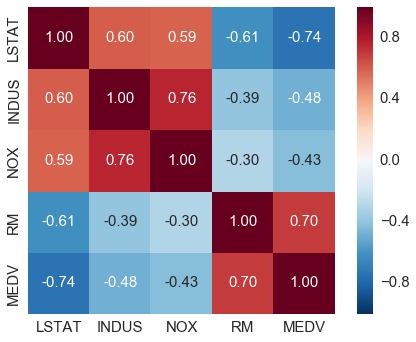

In [6]:
import numpy as np

# compute correlation
cm = np.corrcoef(df[cols].values.T)

# visualize correlation matrix
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)

# plt.tight_layout()
# plt.savefig('./figures/corr_mat.png', dpi=300)
plt.show()

Observations:
* high positive correlation between prices and number of rooms (RM)
* high negative correlation between prices and low-income status (LSTAT)

Thus RM or LSTAT can be good candidates for linear regression

In [7]:
sns.reset_orig()
%matplotlib inline

# Implementing an ordinary least squares linear regression model

Model:
$
y = \sum_{i=0}^n w_i x_i = \mathbf{w}^T \mathbf{x}
$
with $x_0 = 1$.

Given a collection of sample data $\{\mathbf{x^{(i)}}, y^{(i)} \}$, find the line $\mathbf{w}$ that minimizes the regression error:
$$
\begin{align}
L(X, Y, \mathbf{w}) 
= \frac{1}{2} \sum_i \left( y^{(i)} - \hat{y}^{(i)} \right)^2 
= \frac{1}{2} \sum_i \left( y^{(i)} - \mathbf{w}^T \mathbf{x}^{(i)} \right)^2
\end{align}
$$

As usual, the $\frac{1}{2}$ term is for convenience of differentiation, to cancel out the square terms:
$$
\begin{align}
\frac{1}{2} \frac{d x^2}{dx} = x
\end{align}
$$

This is called ordinary least squares (OLS).

## Gradient descent

$$
\begin{align}
\frac{\partial L}{\partial \mathbf{w}}
=
\sum_i \mathbf{x}^{(i)} (\mathbf{w}^t \mathbf{x}^{(i)} - y^{(i)})
\end{align}
$$

$$
\mathbf{w} \leftarrow \mathbf{w} - \eta \frac{\partial L}{\partial \mathbf{w}}
$$

## Solving regression for regression parameters with gradient descent

Very similar to Adaline, without the output binary quantization.

Adaline:
<img src="./images/02_09.png" width=80%>

## Implementation

In [8]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

## Apply LinearRegressionGD to the housing dataset

In [9]:
X = df[['RM']].values
y = df['MEDV'].values

In [10]:
from sklearn.preprocessing import StandardScaler


sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
#y_std = sc_y.fit_transform(y) # deprecation warning
#y_std = sc_y.fit_transform(y.reshape(-1, 1)).ravel()
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [11]:
lr = LinearRegressionGD()
_ = lr.fit(X_std, y_std)

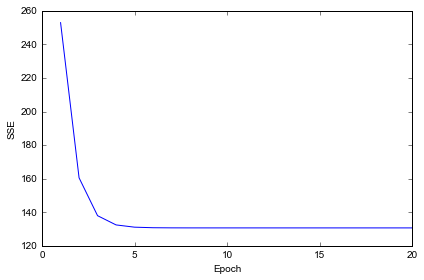

In [12]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.tight_layout()
# plt.savefig('./figures/cost.png', dpi=300)
plt.show()

The optimization converges after about 5 epochs.

In [13]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='lightblue')
    plt.plot(X, model.predict(X), color='red', linewidth=2)    
    return 

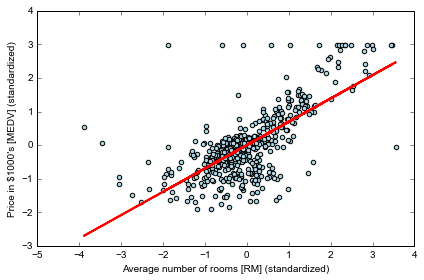

In [14]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.tight_layout()
# plt.savefig('./figures/gradient_fit.png', dpi=300)
plt.show()

The red line confirms the positive correlation between median prices and number of rooms.

But there are some weird things, such as a bunch of points on the celing (MEDV $\simeq$ 3,000) which indicates clipping.

In [15]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


The correlation computed earlier is 0.7, which fits the slope value.

The intercept should be 0 for standardized data.

In [16]:
# use inverse transform to report back the original values
# num_rooms_std = sc_x.transform([[5.0]]) 
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000's: 10.840


## Estimating the coefficient of a regression model via scikit-learn

We don't have to write our own code for linear regression.

Scikit-learn provides various regression models.
* linear and non-linear

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
slr = LinearRegression()
slr.fit(X, y) # no need for standardization
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


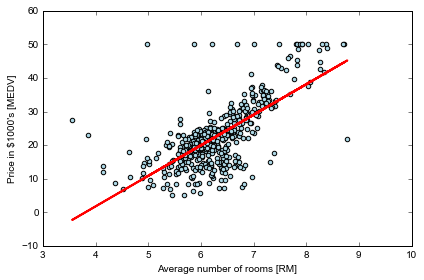

In [19]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.tight_layout()
# plt.savefig('./figures/scikit_lr_fit.png', dpi=300)
plt.show()

**Normal Equations** alternative for direct analytic computing without any iteration:

In [20]:
# adding a column vector of "ones"
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))

print('Slope: %.3f' % w[1])
print('Intercept: %.3f' % w[0])

Slope: 9.102
Intercept: -34.671


# Fitting a robust regression model using RANSAC

Linear regression sensitive to outliers

Not always easy to decide which data samples are outliers

RANSAC (random sample consensus) can deal with this

Basic idea:
1. randomly decide which samples are inliers and outliers
2. fit the line to inliers only
3. add those in outliers close enough to the line (potential inliers)
4. refit using updated inliers
5. terminate if error small enough or iteration enough, otherwise go back to step 1 to find a better model

Can work with different base regressors

## RANSAC in scikit-learn

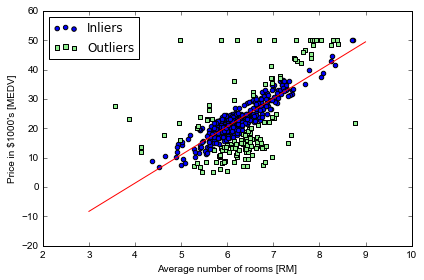

In [21]:
from sklearn.linear_model import RANSACRegressor

if Version(sklearn_version) < '0.18':
    ransac = RANSACRegressor(LinearRegression(), 
                             max_trials=100, 
                             min_samples=50, 
                             residual_metric=lambda x: np.sum(np.abs(x), axis=1), 
                             residual_threshold=5.0, 
                             random_state=0)
else:
    ransac = RANSACRegressor(LinearRegression(), 
                             max_trials=100, 
                             min_samples=50, 
                             loss='absolute_loss', 
                             residual_threshold=5.0, 
                             random_state=0)

ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/ransac_fit.png', dpi=300)
plt.show()

In [22]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 9.621
Intercept: -37.137


# Evaluating the performance of linear regression models

We know how to evaluate classification models.
* training, test, validation datasets
* cross validation
* accuracy, precision, recall, etc.
* hyper-parameter tuning and selection

We can do similar for regression models.

In [23]:
# trainig/test data split as usual
from sklearn.cross_validation import train_test_split

# use all features
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [24]:
slr = LinearRegression()
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

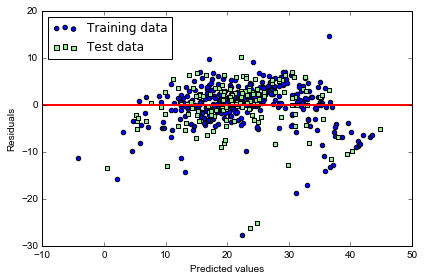

In [25]:
# plot the residuals: difference between prediction and ground truth
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

Perfect regression will have 0 residuals (the red line).

Good regression will have uniform random distribution along that red line.

Other indicate potential problems.
* outliers are far away from the 0 residual line
* patterns indicate information not captured by our model

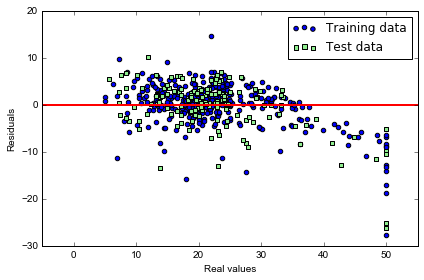

In [26]:
# plot residual against real values
plt.scatter(y_train,  y_train_pred - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(y_test,  y_test_pred - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Real values')
plt.ylabel('Residuals')
plt.legend(loc='best')
plt.hlines(y=0, xmin=-5, xmax=55, lw=2, color='red')
plt.xlim([-5, 55])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

## Statistics for regression

For n data samples with prediction $y$ and ground truth $t$:

### Mean squared error (MSE)

$$
\begin{align}
MSE = \frac{1}{n} \sum_{i=1}^n \left(y^{(i)} - t^{(i)}\right)^2
\end{align}
$$

### Coefficient of determination

Standardized version of MSE

$$
\begin{align}
R^2 &= 1 - \frac{SSE}{SST}
\\
SSE &= \sum_{i=1}^{n} \left( y^{(i)} - t^{(i) }\right)^2
\\
SST &= \sum_{i=1}^{n} \left( t^{(i)} - \mu_t \right)^2
\end{align}
$$

$$
R^2 = 1 - \frac{MSE}{Var(t)}
$$

$R^2 = 1$ for perfect fit
* for training data, $0 \leq R^2 \leq 1$
* for test data, $R^2$ can be $<0$


In [27]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196
R^2 train: 0.765, test: 0.673


# Using regularized methods for regression

$$
\Phi(\mathbf{X}, \mathbf{T}, \Theta) = L\left(\mathbf{X}, \mathbf{T}, \mathbf{Y}=f(\mathbf{X}, \Theta)\right) + P(\Theta)
$$
* $\mathbf{X}$, $\mathbf{T}$: training data
* $f$: our model with parameters $\Theta$ ($\mathbf{w}$ for linear regression so far)
* $L$: accuracy
$$
\begin{align}
L(X, Y, \mathbf{w}) 
= \frac{1}{2} \sum_i \left( y^{(i)} - \hat{y}^{(i)} \right)^2 
= \frac{1}{2} \sum_i \left( y^{(i)} - \mathbf{w}^T \mathbf{x}^{(i)} \right)^2
\end{align}
$$
* $P$: regularization

Reguarlization can help simplify models and reduce overfitting
* e.g. $L_2$ for classification

Popular methods for linear regression:
* ridge regression - $L_2$
* LASSO (least absolute shrinkage and selection operator) - $L_1$
* elastic net - $L_1$ + $L_2$

## Ridge regression

Essentially $L_2$ regularization:
$$
\begin{align}
P\left(\mathbf{w}\right) = \lambda \| \mathbf{w} \|^2
\end{align}
$$

$\lambda$ is the regularization strength as usual.

$$
\begin{align}
\| \mathbf{w} \|^2 = \sum_{j=1}^{m} w_j^2
\end{align}
$$
Do not regularize $w_0$, the bias term.


## LASSO

Essentially $L_1$ regularization:
$$
\begin{align}
P\left(\mathbf{w}\right) = \lambda \| \mathbf{w} \|
\end{align}
$$

$L_1$ tends to produce more $0$ entries than $L_2$, as discussed before.

## Elastic net

Combining $L_1$ and $L_2$ regularization:

$$
\begin{align}
P\left(\mathbf{w}\right) = 
\lambda_1 \| \mathbf{w} \|^2
+
\lambda_2 \| \mathbf{w} \|
\end{align}
$$

# Regularization for regression in scikit learn

In [28]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.1) # alpha is like lambda above
ridge.fit(X_train, y_train)
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)
print(ridge.coef_)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

[ -1.20763405e-01   4.47530242e-02   5.54028575e-03   2.51088397e+00
  -1.48003209e+01   3.86927965e+00  -1.14410953e-02  -1.48178154e+00
   2.37723468e-01  -1.11654203e-02  -1.00209493e+00   6.89528729e-03
  -4.87785027e-01]
MSE train: 19.964, test: 27.266
R^2 train: 0.764, test: 0.673


In [29]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1) # alpha is like lambda above
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

[-0.11311792  0.04725111 -0.03992527  0.96478874 -0.          3.72289616
 -0.02143106 -1.23370405  0.20469    -0.0129439  -0.85269025  0.00795847
 -0.52392362]
MSE train: 20.926, test: 28.876
R^2 train: 0.753, test: 0.653


In [30]:

from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

train_errors = []
test_errors = []

for alpha in alphas:
    model = ElasticNet(alpha=alpha, l1_ratio=0.5)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

print(train_errors)
print(test_errors)

    

[19.97680428517754, 20.309296016712558, 21.048576928265852, 24.381276557501547, 37.240261467371482, 63.612901488320496, 73.891622930755332]
[27.327995983333842, 28.070888490091839, 28.945165625782824, 31.873610817741049, 41.411383902170655, 65.773493017331489, 74.387546652368243]


# Turning a linear regression model into a curve - polynomial regression

Not everything can be explained by linear relationship

How to generalize?

Polynomial regression
$$
\begin{align}
y = w_0 + w_1 x + w_2 x^2 + \cdots + w_d x^d
\end{align}
$$
Still linear in terms of the weights $\mathbf{w}$

# Non-linear regression in scikit learn

Polynomial features
* recall kernel SVM

In [31]:
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])[:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

In [32]:
from sklearn.preprocessing import PolynomialFeatures

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2) # e.g. from [a, b] to [1, a, b, a*a, a*b, b*b]
X_quad = quadratic.fit_transform(X)

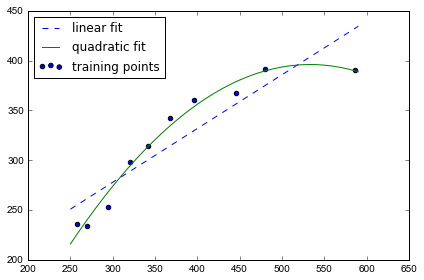

In [33]:
# fit linear features
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# fit quadratic features
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# plot results
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/poly_example.png', dpi=300)
plt.show()

Quadratic polynomial fits this dataset better than linear polynomial

Not always a good idea to use higher degree functions
* cost
* overfit

In [34]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

In [35]:
print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


## Modeling nonlinear relationships in the Housing Dataset

Regression of MEDV (median house price) versus LSTAT

Compare polynomial curves
* linear
* quadratic
* cubic

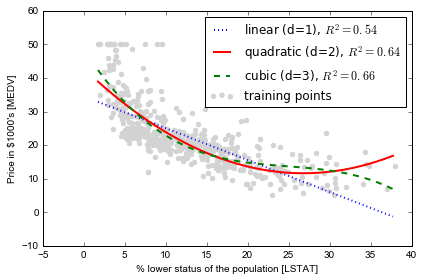

In [36]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')

plt.tight_layout()
# plt.savefig('./figures/polyhouse_example.png', dpi=300)
plt.show()

Transforming the dataset from observation:

$$
\begin{align}
X_{log} &= \log{X}
\\
Y_{sqrt} &= \sqrt{Y}
\end{align}
$$

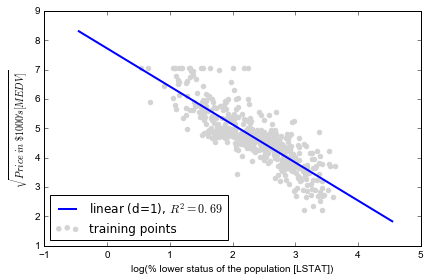

In [37]:
X = df[['LSTAT']].values
y = df['MEDV'].values

# transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# training
regr = regr.fit(X_log, y_sqrt)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# fit features
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]
y_lin_fit = regr.predict(X_fit)

# plot results
plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2)

plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000\'s [MEDV]}$')
plt.legend(loc='lower left')

plt.tight_layout()
# plt.savefig('./figures/transform_example.png', dpi=300)
plt.show()

# Dealing with nonlinear relationships using random forests

Decision trees can be applied for both
* classification (talked about this before)
* regression (next topic)

In classification, we associate a class label for each leaf node.

In regression, we fit a function for each leaf node.

In the simplest case, the function is a constant, which will be the mean of all y values within that node if the loss function is based on MSE.

In this case, the whole tree essentially fits a piecewise constant function to the training data.

Similar to building a decision tree for classification, a decision tree for regression can be built by iteratively splitting each node based on optimizing an objective function, such as MSE mentioned above.
Specifically,
$$IG(D_p) = I(D_p) - \sum_{j=1}^m \frac{N_j}{N_p} I(D_j)$$
, where $IG$ is the information gain we try to maximize for splitting each parent node $p$ with dataset $D_p$, $I$ is the information measure for a given dataset, and $N_p$ and $N_j$ are the number of data vectors within each parent and child nodes.
$m = 2$ for the usual binary split.
For MSE, we have
$$I(D) = \sum_{i \in D} \left|y^{(i)} - \mu_D \right|^2$$
, where $\mu_D$ is the mean of the target $y$ values of the dataset $D$.

## Decision tree regression

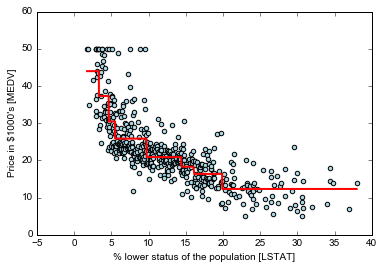

In [38]:
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort() # sort from small to large for plotting below

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
# plt.savefig('./figures/tree_regression.png', dpi=300)
plt.show()

Notice the piecewise constant regions of the decision curve.

## Random forest regression

A random forest is a collection of decision trees
* randomization of training data and features
* generalizes better than individual trees

Can be used for 
* classification (talked about this before)
* regression (next topic)


In [39]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)

In [40]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 1.642, test: 11.052
R^2 train: 0.979, test: 0.878


Overfitting, but still good performance.

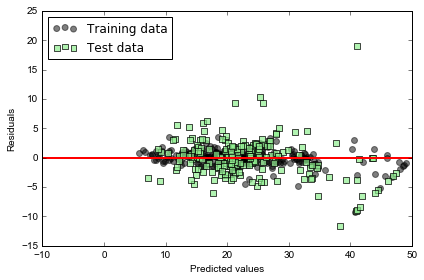

In [41]:
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='black', 
            marker='o', 
            s=35,
            alpha=0.5,
            label='Training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='lightgreen', 
            marker='s', 
            s=35,
            alpha=0.7,
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

Looks better than the results shown above via other regressors.

# Summary

Regression: fit functions to explain continuous variables 

Linear regression: simple and common

General function regression: more powerful but watch out for over-fitting

Analogous to classification in many aspects:
* training via optimization
* traing, validation, test data split
* regularization
* performance metrics
* scikit-learn provides a rich library

RANSAC: a general method for fitting noisy data
* works with different base regressors

We can observe a lot by watching.
* visualize the data before machine learning

# Reading

* PML Chapter 10